In [22]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib
from imutils import paths
import os

In [23]:
dataset_dir = "../data/images/FaceRec"
train_dir = os.path.join(dataset_dir,"trainFaces")
test_dir = os.path.join(dataset_dir,"testFaces")

train_imagepaths = list(paths.list_images(train_dir))
train_labels = [x.split(os.path.sep)[-2] for x in train_imagepaths]

In [24]:
label_mapping = {'vikas': 0,'vaibhaw':1,'satya':2,'Jash':3,'koustubh':4}
inv_label_mapping = dict([(v,k) for k,v in label_mapping.items()])
inv_label_mapping            

{0: 'vikas', 1: 'vaibhaw', 2: 'satya', 3: 'Jash', 4: 'koustubh'}

In [25]:
face_detector = dlib.get_frontal_face_detector()
landmark_detector = dlib.shape_predictor("../data/models/shape_predictor_68_face_landmarks.dat")

In [26]:
resize_height = 64
resize_width = 64

In [27]:
def alignface(image,landmarks,x1,y1):
    left_eye_x = int(landmarks.part(39).x) - x1
    left_eye_y = int(landmarks.part(39).y) - y1
    right_eye_x = int(landmarks.part(42).x) - x1
    right_eye_y = int(landmarks.part(42).y) - y1
    
    dy = right_eye_y - left_eye_y
    dx = right_eye_x - left_eye_x
    
    angle = np.arctan2(dy,dx) * 180/np.pi
    centerx = (left_eye_x + right_eye_x)//2
    centery = (left_eye_y + right_eye_y)//2
    
    warp_mat = cv2.getRotationMatrix2D((centerx,centery),angle,1)
    aligned_face = cv2.warpAffine(image,warp_mat,(image.shape[1],image.shape[0]))
    aligned_face = cv2.resize(aligned_face,(resize_width,resize_height))
    
    return aligned_face

In [28]:
train_faces = []
train_labels_int = []
for imagepath,label in zip(train_imagepaths,train_labels):
    image = cv2.imread(imagepath,0)
    face_rects = face_detector(image,0)
    
    if len(face_rects) == 0:
        continue
        
    x1 = int(face_rects[0].left())
    y1 = int(face_rects[0].top())
    x2 = int(face_rects[0].right())
    y2 = int(face_rects[0].bottom())
    
    new_rect = dlib.rectangle(x1,y1,x2,y2)
    
    landmarks = landmark_detector(image,new_rect)
    
    face_roi = image[y1:y2,x1:x2]
    
    aligned_face = alignface(face_roi,landmarks,x1,y1)
    
    aligned_face = np.float32(aligned_face)/255.0
    
    train_faces.append(aligned_face)
    train_labels_int.append(label_mapping[label])

In [29]:
face_recognizer = cv2.face.LBPHFaceRecognizer_create()

face_recognizer.train(train_faces,np.array(train_labels_int))

face_recognizer.write("../data/models/face_model.yml")

In [30]:
face_recognizer = cv2.face.LBPHFaceRecognizer_create()
face_recognizer.read("../data/models/face_model.yml")

In [31]:
cap = cv2.VideoCapture(0)

In [32]:
while True:
    
    ret,frame = cap.read()
    
    if not ret:
        break
        
    frame_gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    
    face_rects = face_detector(frame_gray,0)
    
    if len(face_rects) == 0:
        continue
        
    x1 = int(face_rects[0].left())
    y1 = int(face_rects[0].top())
    x2 = int(face_rects[0].right())
    y2 = int(face_rects[0].bottom())
    
    new_rect = dlib.rectangle(x1,y1,x2,y2)
    
    landmarks = landmark_detector(frame_gray,new_rect)
    
    face_roi = frame_gray[y1:y2,x1:x2]
    
    aligned_face = alignface(face_roi,landmarks,x1,y1)
    
    aligned_face = np.float32(aligned_face)/255.0
    
    label,score = face_recognizer.predict(aligned_face)
    
    
    
    person_name = inv_label_mapping[label]
    
    cv2.rectangle(frame,(x1,y1),(x2,y2),(0,255,0))
    cv2.putText(frame,"Name : {} Score: {:.3f}".format(person_name,score),(10,25),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,0,255))
    
    cv2.imshow("frame",frame)
    k = cv2.waitKey(1)
    if k == ord('q'):
        break
        
    
cap.release()
cv2.destroyAllWindows()

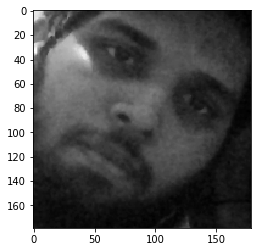

In [33]:
plt.imshow(face_roi,cmap = 'gray')

In [34]:
face = alignface(face_roi,landmarks,x1,y1)

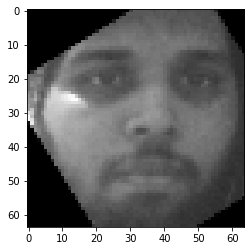

In [35]:
plt.imshow(face,cmap = "gray")